In [2]:
# imports
import os
import random
from dotenv import load_dotenv
from huggingface_hub import login
from datasets import load_dataset, Dataset, DatasetDict
from utils.items import Item
from utils.loaders import ItemLoader
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import numpy as np
import pickle

KeyboardInterrupt: 

In [ ]:
load_dotenv()
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [ ]:
hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [ ]:
%matplotlib inline

In [ ]:
# Load in the same dataset as last time

items = ItemLoader("Appliances").load()

Loading dataset Appliances


100%|██████████| 95/95 [03:20<00:00,  2.11s/it] 


Completed Appliances with 28,625 datapoints in 3.7 mins


In [ ]:
# Look for a familiar item..
print(items[1].prompt)

How much does this cost to the nearest dollar?

Door Pivot Block - Compatible Kenmore KitchenAid Maytag Whirlpool Refrigerator - Replaces - Quick DIY Repair Solution
Pivot Block For Vernicle Mullion Strip On Door - A high-quality exact equivalent for part numbers and Compatibility with major brands - Door Guide is compatible with Whirlpool, Amana, Dacor, Gaggenau, Hardwick, Jenn-Air, Kenmore, KitchenAid, and Maytag. Quick DIY repair - Refrigerator Door Guide Pivot Block Replacement will help if your appliance door doesn't open or close. Wear work gloves to protect your hands during the repair process. Attentive support - If you are uncertain about whether the block fits your refrigerator, we will help. We generally put forth a valiant effort to guarantee you are totally

Price is $17.00


In [ ]:
#Let's look at all datasets of all the items that you might find in a 
# large home retail store
dataset_names = [
    "Electronics",
    "Appliances"
    ]

In [ ]:
items = []
for dataset_name in dataset_names:
    loader = ItemLoader(dataset_name)
    items.extend(loader.load())

# Takes a lot of time increase dataset list size for more items

Loading dataset Electronics


100%|██████████| 1611/1611 [1:00:53<00:00,  2.27s/it]


Completed Electronics with 443,473 datapoints in 61.8 mins
Loading dataset Appliances


100%|██████████| 95/95 [02:29<00:00,  1.57s/it] 


Completed Appliances with 28,625 datapoints in 2.7 mins


In [ ]:
print(f"A grand total of {len(items):,} items")

A grand total of 472,098 items


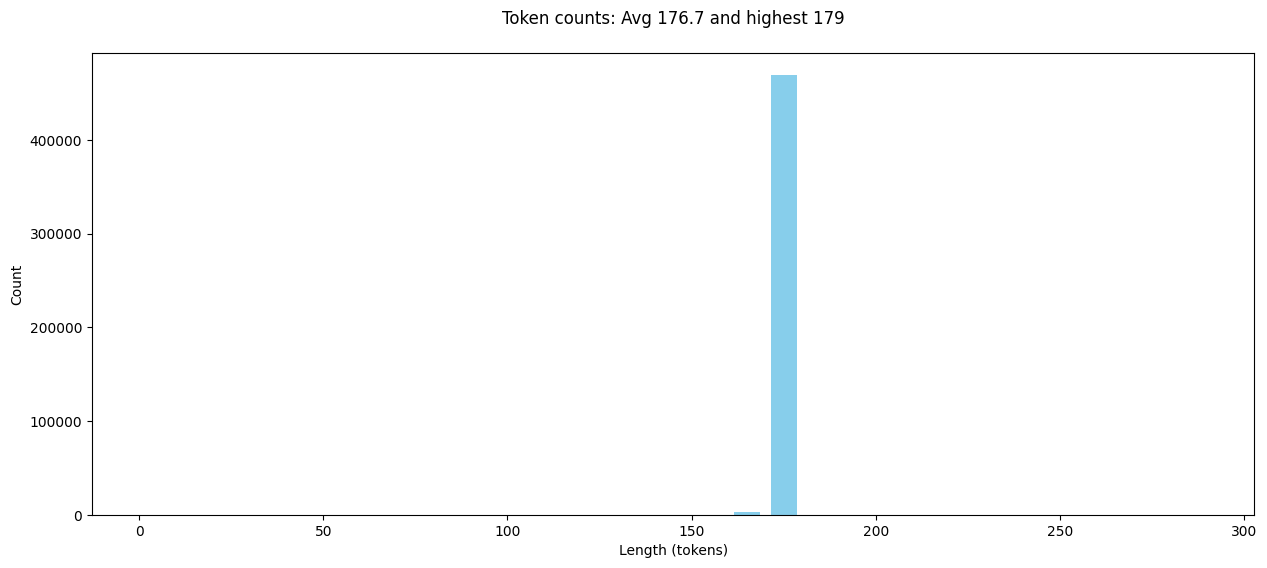

In [ ]:
# Plot the distribution of token counts again

tokens = [item.token_count for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Token counts: Avg {sum(tokens)/len(tokens):,.1f} and highest {max(tokens):,}\n")
plt.xlabel('Length (tokens)')
plt.ylabel('Count')
plt.hist(tokens, rwidth=0.7, color="skyblue", bins=range(0, 300, 10))
plt.show()

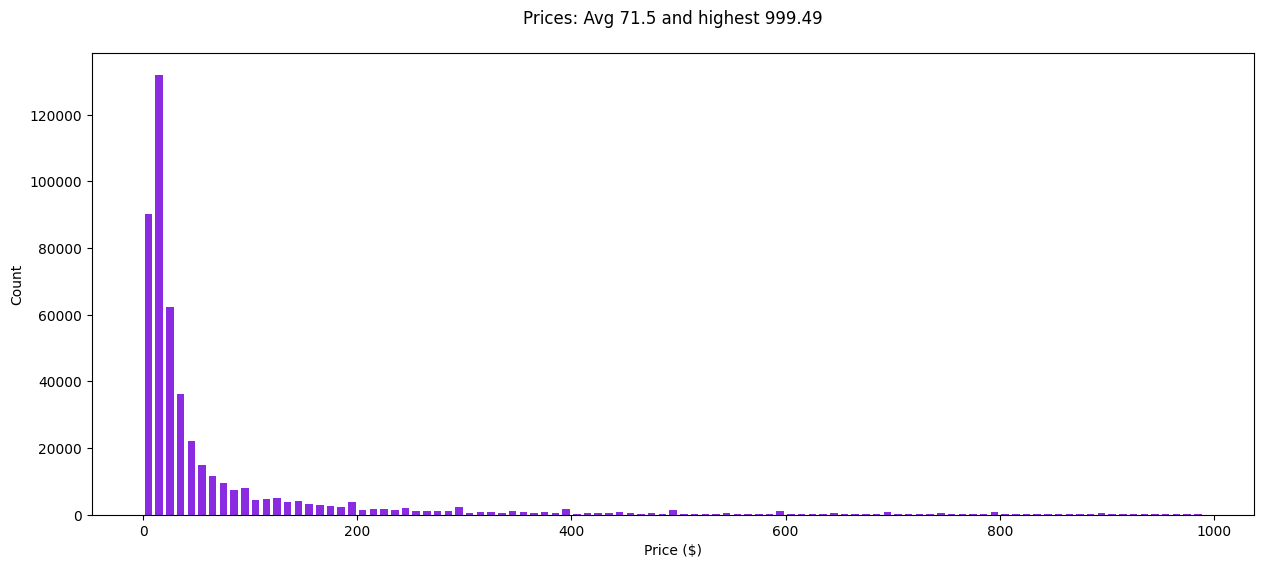

In [ ]:
# Plot the distribution of prices

prices = [item.price for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.1f} and highest {max(prices):,}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="blueviolet", bins=range(0, 1000, 10))
plt.show()

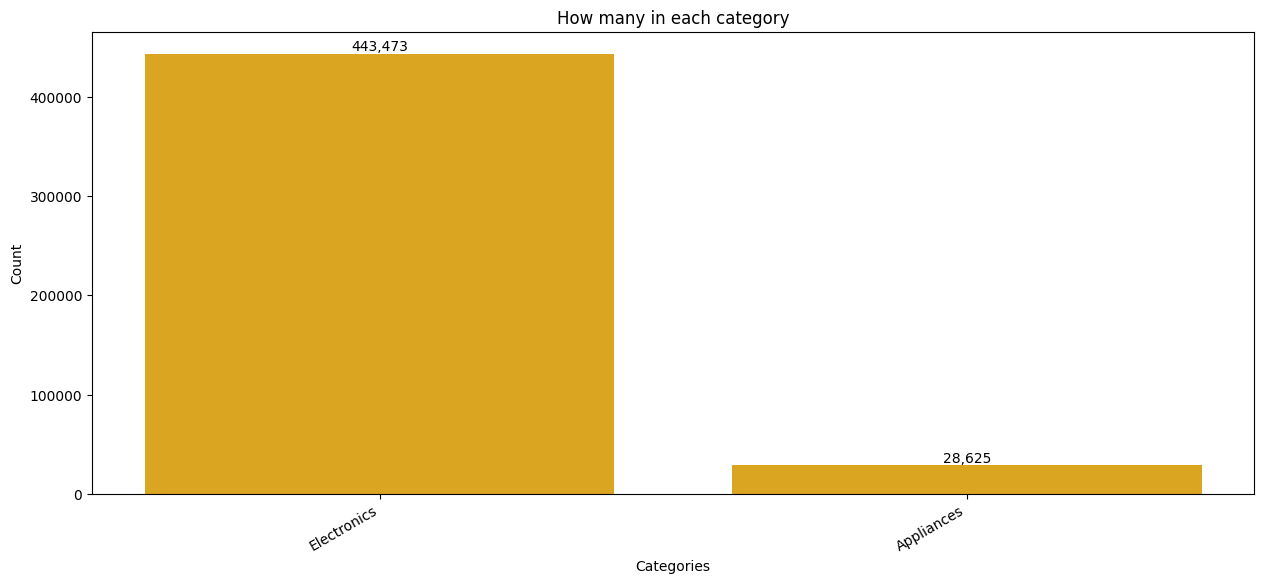

In [ ]:
category_counts = Counter()
for item in items:
    category_counts[item.category]+=1

categories = category_counts.keys()
counts = [category_counts[category] for category in categories]

# Bar chart by category
plt.figure(figsize=(15, 6))
plt.bar(categories, counts, color="goldenrod")
plt.title('How many in each category')
plt.xlabel('Categories')
plt.ylabel('Count')

plt.xticks(rotation=30, ha='right')

# Add value labels on top of each bar
for i, v in enumerate(counts):
    plt.text(i, v, f"{v:,}", ha='center', va='bottom')

# Display the chart
plt.show()

## Dataset is far too skewed to work with we need to balance it out!

In [ ]:
# Create a dict with a key of each price from $1 to $999
# And in the value, put a list of items with that price (to nearest round number)

slots = defaultdict(list)
for item in items:
    slots[round(item.price)].append(item)

In [ ]:
# Create a dataset called "sample" which tries to more evenly take from the range of prices
# And gives more weight to items from categories other than Automotive
# Set random seed for reproducibility

np.random.seed(42)
random.seed(42)
sample = []
for i in range(1, 1000):
    slot = slots[i]
    if i>=140:
        sample.extend(slot)
    elif len(slot) <= 999:
        sample.extend(slot)
    else:
        weights = np.array([1 if item.category=='Electronics' else 5 for item in slot])
        weights = weights / np.sum(weights)
        selected_indices = np.random.choice(len(slot), size=999, replace=False, p=weights)
        selected = [slot[i] for i in selected_indices]
        sample.extend(selected)

print(f"There are {len(sample):,} items in the sample")

There are 158,403 items in the sample


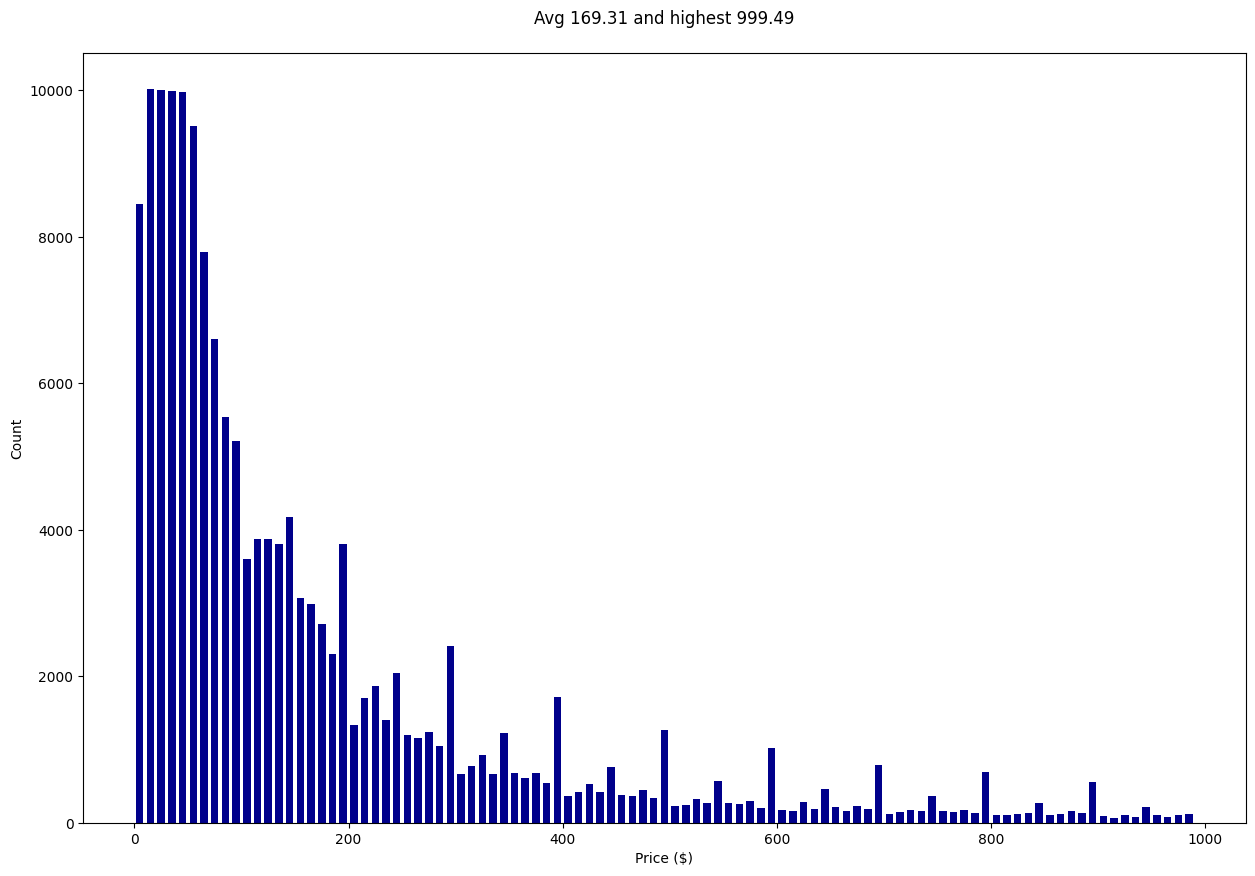

In [ ]:
# Plot the distribution of prices in sample

prices = [float(item.price) for item in sample]
plt.figure(figsize=(15, 10))
plt.title(f"Avg {sum(prices)/len(prices):.2f} and highest {max(prices):,.2f}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="darkblue", bins=range(0, 1000, 10))
plt.show()

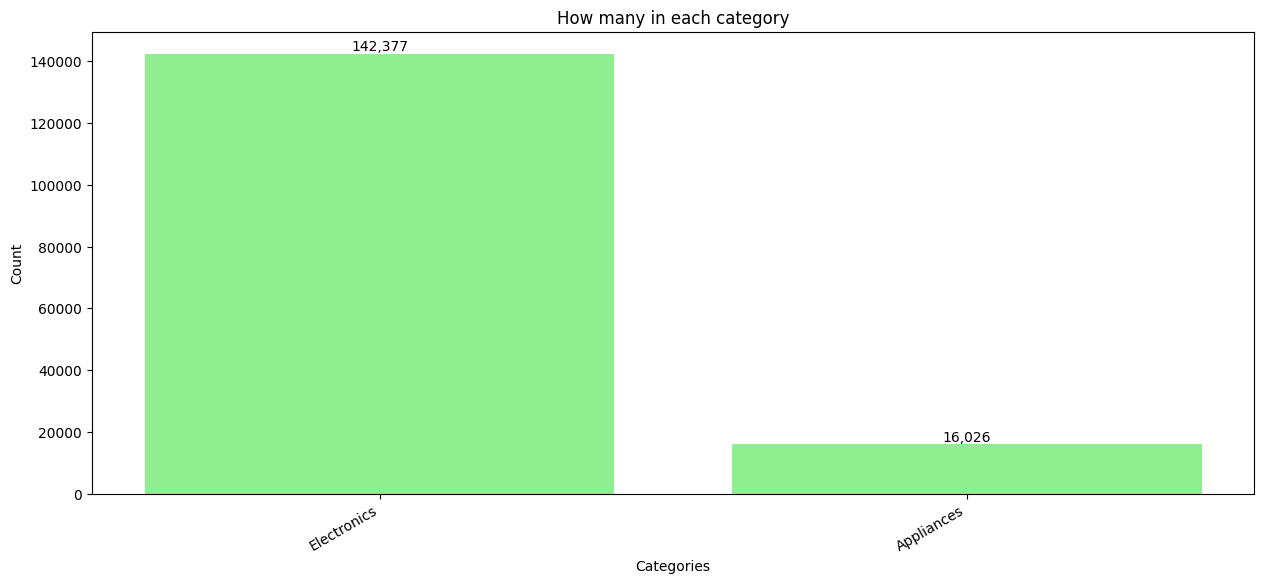

In [ ]:
# OK, we did well in terms of raising the average price and having a smooth-ish population of prices
# Let's see the categories

category_counts = Counter()
for item in sample:
    category_counts[item.category]+=1

categories = category_counts.keys()
counts = [category_counts[category] for category in categories]

# Create bar chart
plt.figure(figsize=(15, 6))
plt.bar(categories, counts, color="lightgreen")

# Customize the chart
plt.title('How many in each category')
plt.xlabel('Categories')
plt.ylabel('Count')

plt.xticks(rotation=30, ha='right')

# Add value labels on top of each bar
for i, v in enumerate(counts):
    plt.text(i, v, f"{v:,}", ha='center', va='bottom')

# Display the chart
plt.show()

## Balanced enough for a real world dataset!

In [ ]:
def report(item):
    prompt = item.prompt
    tokens = Item.tokenizer.encode(item.prompt)
    print(prompt)
    print(tokens[-10:])
    print(Item.tokenizer.batch_decode(tokens[-10:]))

In [ ]:
report(sample[40001])

How much does this cost to the nearest dollar?

MegaGear MG1014 Ever Ready Leather Camera Case compatible with Sony Alpha A6500
Leather Flap closure BESPOKE FIT - The MegaGear Premium Leather Camera Case with Battery Access is specifically tailored for the Sony Alpha A6500 (up to lens) for coverage. ENHANCED PROTECTION - Due to its rugged construction and tailored fit it provides maximal protection for your camera against bumps, damage and shock. Protects your Lens and LCD from scratches. FUNCTIONAL ACCESSIBILITY - The Ever Ready is designed for efficient photography. You can access all peripheral ports, card slots, buttons, tripod, and the battery without removing your case. CONVENIENT - Convenience features allow rapid use of your camera when needed, taking that impulsive shoot is as easy as flipping the top cover open

Price is $42.00
[1948, 3504, 1825, 271, 7117, 374, 400, 2983, 13, 410]
[' top', ' cover', ' open', '\n\n', 'Price', ' is', ' $', '42', '.', '00']


In [ ]:
random.seed(42)
random.shuffle(sample)
train = sample[:int(len(sample)*0.9)]
test = sample[int(len(sample)*0.9):]
print(f"Train: {len(train):,} Test: {len(test):,}")

Train: 142,562 Test: 15,841


In [ ]:
print(train[0].prompt)
print(train[0].test_prompt())

NameError: name 'train' is not defined

In [ ]:
train_prompts = [item.prompt for item in train]
train_prices = [item.price for item in train]
test_prompts = [item.test_prompt() for item in test]
test_prices = [item.price for item in test]

In [ ]:
## Time to upload to the hub

In [ ]:
# Create a DatasetDict
train_dataset = Dataset.from_dict({"text":train_prompts, "price":train_prices})
test_dataset = Dataset.from_dict({"text":test_prompts, "price":test_prices})

dataset = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})

In [ ]:
# DATASET_NAME = "rohitsharma77/pricer-data"
# dataset.push_to_hub(DATASET_NAME, private=True, token=hf_token)
# print(f"Dataset {DATASET_NAME} uploaded to the Hugging Face Hub.")

In [ ]:
with open("train.pkl", "wb") as f:
    pickle.dump(train, f)
with open("test.pkl", "wb") as f:
    pickle.dump(test, f)